**Models**

**Quarter Back**

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [7]:
all_games = pd.read_csv('nfl-football-player-stats/games_1995.csv')
all_games.drop([440917], inplace=True) # delete weird Lagerrete Blount double game
all_games.loc[all_games['team'] == 'SDG', 'team'] = 'LAC'
all_games.loc[all_games['team'] == 'STL', 'team'] = 'LAR'
all_games.loc[all_games['opponent'] == 'SDG', 'opponent'] = 'LAC'
all_games.loc[all_games['opponent'] == 'STL', 'opponent'] = 'LAR'
all_games = all_games.set_index('player_id')
all_players = pd.read_csv('nfl-football-player-stats/players_1995.csv',index_col='player_id')

In [22]:
data = pd.read_csv('qbs_2014_2017.csv', index_col='player_id')
data = data.drop(columns=['ewma_receiving_targets'])
data = data.fillna(0)

In [24]:
# Tuning parameter for RF
# 350 is best
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=3)

#get 2014-2016
features = ['log_draft_position','log_num_games','ewma_fpts','ewma_team_rush_attempts','ewma_team_rush_percentage','ewma_team_passing_rating','ewma_rushing_attempts','DY/P','TO']
resp = ['next_fpts']
trainX2016 = data.loc[data['year'] < 2017][features]
trainy2016 = data.loc[data['year'] < 2017][resp]

# re index
trainX2016.reset_index(drop=True, inplace=True)
trainy2016.reset_index(drop=True, inplace=True)

range_est = [200,250,300,350,400]
mses = [0,0,0,0,0]
maes = [0,0,0,0,0]

for train_index, test_index in kf.split(trainX2016):
    X_train, X_test = trainX2016.iloc[train_index], trainX2016.iloc[test_index]
    y_train, y_test = trainy2016.iloc[train_index], trainy2016.iloc[test_index]
    for j in range(len(range_est)):
        rf_model = RandomForestRegressor(n_estimators=range_est[j])
        rf_model.fit(X_train, y_train)
        preds = rf_model.predict(X_test)
        mses[j] += mean_squared_error(y_test, preds)
        maes[j] += mean_absolute_error(y_test, preds)
print(mses)
print(maes)

C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vec

[428.36596954453535, 428.66470293933685, 427.34742194450234, 426.5034569280632, 426.8910188743402]
[37.09588847583643, 37.0898215613383, 37.02797348203222, 36.965542432288906, 36.98859163568774]


In [32]:
# Training on the 2017 season
MSEarma = []
MAEarma = []
MSElr = []
MAElr = []
MSErf = []
MAErf = []
MSEbase = []
MAEbase = []

for w in range(1,11):
    print(w)
    WEEK = w
    POSITION = 'QB'
    YEAR = 2017

    features = ['log_draft_position','log_num_games','ewma_fpts','ewma_team_rush_attempts','ewma_team_rush_percentage','ewma_team_passing_rating','ewma_rushing_attempts','DY/P','TO']
    resp = ['next_fpts']
    X_train = data.loc[data['year'] < 2017][features]
    X_traincurr = data.loc[(data['year'] == 2017) & (data['game_number'] < WEEK)][features]
    if len(X_traincurr)>0:
        X_train = X_train.append(X_traincurr)
    y_train = data.loc[data['year'] < 2017][resp]
    y_traincurr = data.loc[(data['year'] == 2017) & (data['game_number'] < WEEK)][resp]
    if len(y_traincurr)>0:
        y_train = y_train.append(y_traincurr) 
    X_test = data.loc[(data['year'] == 2017) & (data['game_number']==WEEK)][features]
    y_test = data.loc[(data['year'] == 2017) & (data['game_number']==WEEK)][resp]

    # Fitting models

    # naive approach
    preds = data.loc[(data['year'] == 2017) & (data['game_number']==WEEK)]['fpts']
    MAEbase.append(mean_absolute_error(y_test, preds))
    MSEbase.append(mean_squared_error(y_test, preds))

    # ARMA
    '''
    players = get_players_thatweek(all_games, all_players, POSITION, YEAR, WEEK, subset_position)
    X, resp = get_features_response_ARMA(players, all_games, YEAR, WEEK, half_ppr)
    preds = []
    for i in resp.index:
        if type(X.loc[i]['fpts']) != np.float64:
            past_fpts = X.loc[i]['fpts'].values
            model = ARMA(past_fpts, (0,1))
            model_fit = model.fit(disp=0)
            preds.append(model_fit.forecast()[0][0])
        else:
            resp.drop([i],inplace=True)
    MAEarma.append(mean_absolute_error(resp, preds))
    MSEarma.append(mean_squared_error(resp, preds))
    '''

    # linear regression
    XtrainS = StandardScaler().fit_transform(X_train)
    XtestS = StandardScaler().fit_transform(X_test)
    lr = LinearRegression()
    lr.fit(XtrainS, y_train)
    preds = lr.predict(XtestS)
    MAElr.append(mean_absolute_error(y_test, preds))
    MSElr.append(mean_squared_error(y_test, preds))

    # random forest
    rf = RandomForestRegressor(n_estimators = 350)
    rf.fit(XtrainS, y_train)
    preds = rf.predict(XtestS)
    MAErf.append(mean_absolute_error(y_test, preds))
    MSErf.append(mean_squared_error(y_test, preds))

1


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


2


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


3


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


4


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


5


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


6


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


7


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


8


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


9


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


10


C:\Users\Chloe\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [34]:
lr.score(XtestS, y_test)

0.07349988136136287

In [35]:
print("RF: ",MAErf)
print("RF: ", MSErf)
print("LR: ",MAElr)
print("LR: ", MSElr)
print("baseline: ",MAEbase)
print("baseline: ", MSEbase)
print("ARMA: ",MAEarma)
print('ARMA: ', MSEarma)

RF:  [6.72343842364532, 9.813516071428566, 7.779522580645162, 8.037599999999996, 7.005063265306116, 8.332163809523802, 6.37347724867724, 5.04791152073733, 7.244009523809528, 7.342687557603686]
RF:  [64.38305182119636, 134.7139474996938, 95.87197450606976, 97.54607602982303, 78.43851932303205, 114.18612331863936, 66.35229114170816, 46.19011292060565, 80.29516105414973, 73.3809134681238]
LR:  [6.087880384198846, 9.608470285437694, 7.765143893052526, 7.582211522994354, 6.583423385126266, 8.295633908433377, 5.886494613144179, 4.754244515909968, 6.879872643692284, 7.561012253995443]
LR:  [54.3366303999155, 126.01249143890068, 92.02480021611306, 87.53372465521738, 71.29313780992773, 108.65506201698555, 58.111011234759545, 42.823750956501925, 73.54219427948877, 77.60635404490665]
baseline:  [7.3227586206896556, 11.949375, 10.261935483870968, 7.898000000000001, 8.018571428571429, 10.053333333333335, 9.559259259259258, 7.185806451612903, 8.53, 9.04258064516129]
baseline:  [88.31409655172415, 20

Plot

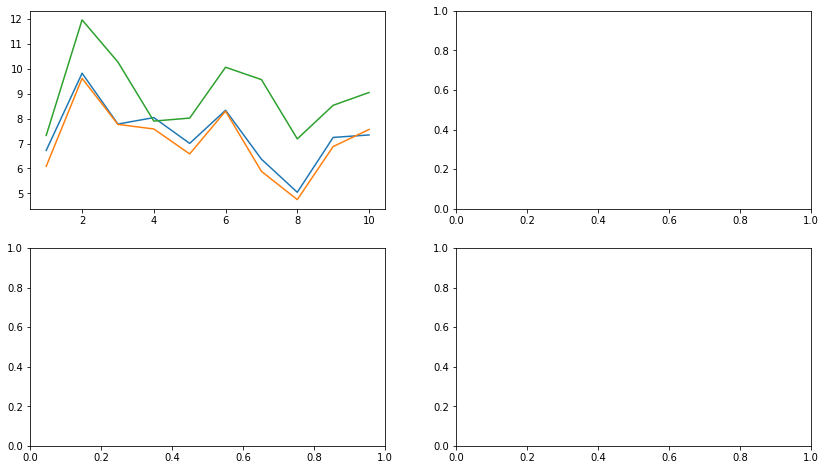

In [36]:
fig, axs = plt.subplots(2,2, figsize=(14,8))
weeks = range(1,11)
axs[0,0].plot(weeks, MAErf)
axs[0,0].plot(weeks, MAElr)
axs[0,0].plot(weeks, MAEbase)

Helpful Functions

In [17]:
def get_players_thatweek(all_games, all_players, position, year, game_number, subset_position, specific_players=None):
    if specific_players != None:
        ids = specific_players
    else:
        ids = all_players[all_players.position == position].index
        
    # return pandas df with player_id as index and player name and log draft position columns
    games = all_games.loc[ids]
    stats = subset_position[position][0]
    sum_threshold = subset_position[position][1]
    # only take RBs with 5 rush attempts or receiving targets (>= sum_threshold)
    worth_predicting = games[(games.year == year) & 
                             (games.game_number == game_number) &
                             (np.sum(games[stats], axis=1) >= sum_threshold)]
    ids = worth_predicting.index
    for_df = all_players.loc[ids, ['name', 'draft_position']]
    # players that weren't drafted give them position of last pick of draft
    for_df.fillna(255, inplace=True)
    for_df['log_draft_position'] = np.log(for_df.draft_position)
    return pd.DataFrame(data=for_df)

In [20]:
half_ppr = {
    'rushing_yards': 0.1,
    'rushing_touchdowns': 6,
    'receiving_receptions': 0.5,
    'receiving_yards': 0.1,
    'receiving_touchdowns': 6
}

In [190]:
# subset RB position by choosing only RBs with at least 3 fantasy points in previous game
subset_position = {
    'RB': [['rushing_attempts', 'receiving_targets'], 5.0],
    'WR': [['rushing_attempts', 'receiving_targets'], 5.0],
    'QB': [['passing_attempts'], 10.0]
}

In [43]:
def get_features_response_ARMA(players, all_games, year, gameNumber, points_dict):
    games = all_games.loc[players.index]
    
    # compute fpts for each row
    games['fpts'] = games['game_number']*0
    for stat, value in zip(points_dict.keys(), points_dict.values()):
        games['fpts'] = games['fpts'] + games[stat]*value

    prev_years = games[(games.year < year) &
                       (games.game_number <= 16)]
    current_year = games[(games.year == year) &
                         (games.game_number <= gameNumber)]
    next_game = games[(games.year == year) &
                     (games.game_number == gameNumber+1)]
    
    df = pd.concat((prev_years, current_year))
    df.sort_values(by=['player_id', 'year', 'game_number'], axis=0,
                   ascending=False, inplace=True)
    # group dataframe by index
    df = df.groupby(df.index)
    
    past_16 = df.nth(list(range(0,16))).fpts
    weeks = df.nth(list(range(0,16))).game_number
    years = df.nth(list(range(0,16))).year
    
    # get response variable, the next game fantasy points 
    resp = next_game['fpts']

    for_return = pd.concat([past_16, years, weeks], axis=1)
    for_return.sort_values(by=['player_id', 'year', 'game_number'], axis=0, ascending=False, inplace=True)
    resp = resp.sort_index(ascending=False)
    return for_return, resp